In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import scipy
import scipy.misc
import scipy.signal
import warnings
import os
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#plt.rcParams['figure.figsize'] = (50,50)
plt.rcParams['image.cmap'] = 'gray'
import mrc as mrc
import statistics
import imageio
import ctf
import pickle
import copy
import time
#import skimage
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

##Particle sorting and CTF testing
Using the previous code, I implemented the small change to the sigma estimation, and increase the number of outputs.

The following code outputs $-\log P(T^k|I)$, $-\log P(I|T^k)$, $-\log P(I)$, $P(T^k|I)$. 

24.847887922091854
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere


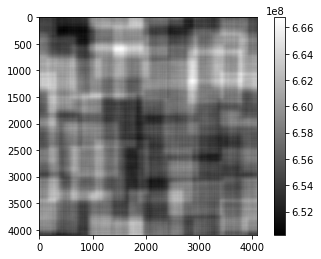

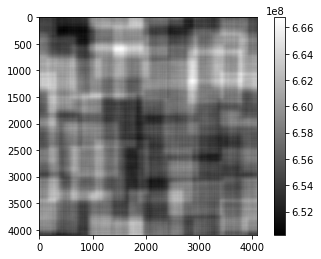

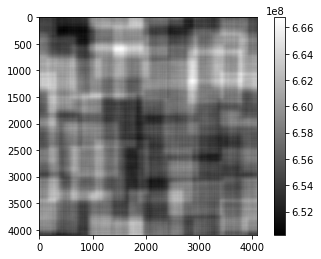

In [4]:
%%time
#Version 3 - Taking in a folder with stacks of a particle in different configurations and producing probabilities.
#Implementing sigma as a parameter and estimation.

def Config_Prob(I, folder, max_num = 10, method = 1, sigma = None, psk = []):
    I = mrc.readMRC(I)
    I = I[:,:,0]
    h , l = I.shape
    
    num_configs = len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name)) and name[0] != '.'])
    
    if sigma is None:
        #Calculate variance for 5 points, 10 times and take median
        avg_num = 50
        sample_num = 100
        sigma_list = np.empty([avg_num,1])
        for nn in range(avg_num):

            x = np.random.randint(0, h, size = sample_num)
            y = np.random.randint(0,l, size = sample_num)
            vbar = 0
            
            for mm in range(sample_num):
                vbar = vbar + I[x[mm]][y[mm]]
                
            sigma = 0
            vbar = vbar * 1/sample_num
            
            for mm in range(sample_num):
                sigma = sigma + (I[x[mm]][y[mm]]- vbar)**2
                
            sigma = sigma * 1/sample_num
            sigma_list[nn] = np.sqrt(sigma)
            
        sigma = np.median(sigma_list)
        
    else:
        None
        
    print(sigma)
        
    ek_stack = np.empty([num_configs, h, l])
    prob_stack = np.empty([num_configs, h, l])
    prob_stack2 = np.empty([num_configs, h, l])
    
    padding = np.zeros_like(I)
    mask = np.zeros_like(I)
    
    f1 = np.fft.rfft2(I)
    
    if method == 1:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l, sigma)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('outerloop')
            
        ek_sum = scipy.misc.logsumexp(-ek_stack, axis = 0)
               
        
        for temp_stack in range(len(os.listdir(folder))):
            
            
            prob = (ek_stack[temp_stack,:,:] + ek_sum)
            
            prob_stack[temp_stack,:,:] = prob
            
            prob_stack2[temp_stack,:,:] = np.exp(-prob)
            
        return (prob_stack, ek_stack, ek_sum, prob_stack2) 
    
    else:
        count = 0
        
       
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l, sigma)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('outerloop')
            
        for temp_stack in range(len(os.listdir(folder))):
            
            ek_sum = scipy.misc.logsumexp((np.log(psk[temp_stack])-ek_stack),axis = 0)
            
            prob = -np.log(psk[temp_stack]) + ek_stack[temp_stack,:,:] + ek_sum
            
            prob_stack[temp_stack,:,:] = prob
            prob_stack2[temp_stack,:,:] = np.exp(-prob)
        
        return (prob_stack, ek_stack, ek_sum, prob_stack2)
        
def Error_Template(I, T, max_num, f1, padding, mask, h, l, sigma):
    x, y, z = T.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    f2 = np.fft.rfft2(padding)
    
    ek = Template_Splitting(I,T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, sigma)
    
    return ek

def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, sigma, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ejk_stack_2 = np.empty([inx_len, h, l])
          
        ejk_stack = np.empty([max_num,h, l])
        
        img_norm = fast_convolve(I**2, padding, PFT = f2)
        
        plt.figure()
        plt.imshow(img_norm)
        plt.colorbar()
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([z-index[nn],h,l])      
            
            for xx in range(zed.shape[2]):

                temp = zed[:,:,xx]
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                temp_norm = np.sum(temp**2)        
                
                
                ejk_stack[xx,:,:] = (1/(2*sigma**2))*(temp_norm - 2*crossc)
                #ejk_stack[xx,:,:] = (1/(2*sigma**2))*(img_norm + temp_norm - 2*crossc)
                print('heythere')
            
            ejk_stack_2[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
            print('innerloop')
           
            
        
        return ejk_stack_2
                       
    
def fast_convolve(I, T, IFT = None, PFT = None):   
    if IFT is None:
        IFT = np.fft.rfft2(I)

    if PFT is None:
        PFT = np.fft.rfft2(T)

    fc = np.fft.fftshift(np.fft.irfft2(IFT*PFT)) 
   
    return fc        
    
z1 = Config_Prob('imgdata_30008_1.mrc', 'test_folder_3', psk = [0.1, 0.9], method = 1)

In [3]:
z1 = np.load('30004_z1.npy')

This is my algorithm, it takes P(I), and iterates over the maximum values until it hits a certain threshold (max+min/2). It saves the location of the maximum in a list, and then creates a circular mask over the region of radius r. It then loops through the particles and stores the mean of P(T^k|I)/median P(I|T^k) in a particle-specific dictionary. It then compares these values and puts a coloured square on the image, corresponding to the particle it believes it is.

This value of the mean/median doesnt make sense, but it works with the images and somehow produces the desired results.

The smaller particle can be detected if the image is looped over again with a smaller threshold, however that also isnt intitive to do, so it is ommitted from the picking. 

38 0
{} 

 {(3904, 1545): 0.9342504585612776, (2946, 3195): 0.933209224748939, (714, 2946): 0.9338932467410243, (2962, 1011): 0.9334144108230795, (1929, 227): 0.9339464303814791, (3926, 3945): 0.9345471811839854, (644, 1320): 0.9339721404750894, (2932, 3586): 0.9335590454029206, (3432, 178): 0.9354269795774707, (2865, 2021): 0.9337386872185949, (3957, 3469): 0.932792703943578, (196, 840): 0.9279444082477456, (879, 3774): 0.9298190771390134, (3355, 1096): 0.9280511472418758, (1455, 124): 0.935215388429281, (1313, 1941): 0.9348356036437782, (672, 1971): 0.930348644281722, (1572, 645): 0.935078673577231, (2214, 3741): 0.9343580232526787, (1941, 1046): 0.9340708967030951, (221, 3503): 0.9286347981818639, (1476, 3812): 0.9304727335184714, (3953, 2991): 0.9283410634128657, (2529, 2503): 0.930746097298711, (1084, 2949): 0.9293744553336244, (2446, 1314): 0.9306407047161899, (1101, 1010): 0.9300590195078013, (3777, 830): 0.9289084133895563, (3331, 1693): 0.9305635044070695, (993, 2488): 0.92932

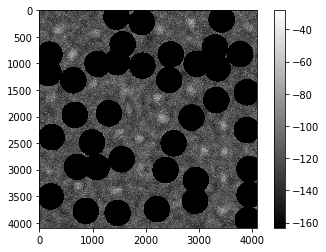

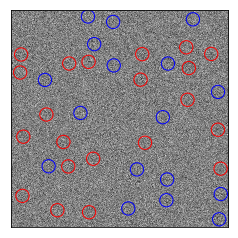

In [6]:
%%time
#old peak finding algorithm
#This works for 30004 and 30006 30005 30010 30009
binsize = (250, 250)

img = copy.copy(z1[2])
img2 = scipy.misc.imread('30008_png.png', 1)
img3 = copy.copy(-z1[1][0])
img4 = copy.copy(-z1[1][0])

n = 4096
r = 250

part1, part2, part3 = 0, 0, 0
k,j = 0,0
list1 = []
dictlist = []

for xx in range(z1[0].shape[0]):
    dictlist.append({})

    
while np.amax(img)>(np.amax(z1[2])+np.amin(z1[2]))/2:
    if k > 70:
        break
    else:
        x = np.argmax(img)%4096
        y = np.argmax(img)//4096
        list1.append([x,y])
        b, a = np.ogrid[-y:n-y, -x:n-x]
        mask = b*b + a*a <= r*r
        for xx in range(z1[0].shape[0]):
            if np.mean(z1[0][xx]) != 0.0:
                
                dictlist[xx][(x,y)] = np.mean(z1[0][xx][mask])/np.median(z1[1][xx][mask])
               
        img[mask] = np.amin(img)
        img3[mask] = np.amin(img3)
        
        k += 1
        
# while np.amax(img3)>np.mean(img4)*0.7:
    
#     if j > 30:
#         break
#     else:
#         x = np.argmax(img3)%4096
#         y = np.argmax(img3)//4096
#         list1.append([x,y])
#         b, a = np.ogrid[-y:n-y, -x:n-x]
#         mask = b*b + a*a <= r*r
        
#         dictlist[0][(x,y)] = np.mean(z1[0][0][mask])/np.median(z1[1][0][mask])

#         img[mask] = -np.amin(img)
#         img3[mask] = np.amin(img3)
        
#         j += 1
        
        
print(k, j)
plt.figure()
plt.imshow(img3)
plt.colorbar()
print(dictlist[0], '\n\n', dictlist[1], '\n\n', dictlist[2])


# for tt in dictlist[1].keys():
#     if dictlist[1][tt] > dictlist[2][tt]:
#         img2[tt[1]-10:tt[1]+10, tt[0]-10:tt[0]+10] = 0
#         part3 += 1
#         try:
#             del dictlist[0][tt]
#         except KeyError:
#             None
#     else:
#         img2[tt[1]-10:tt[1]+10, tt[0]-10:tt[0]+10] = 255
#         part2 += 1
#         try:
#             del dictlist[0][tt]
#         except KeyError:
#             None
# for rr in dictlist[0].keys():
#     img2[rr[1]-20:rr[1]+20, rr[0]-20:rr[0]+20] = 0
#     part1 += 1
    
    
fig,ax = plt.subplots(1)
ax.imshow(img2)
ax.set_xticks([])
ax.set_yticks([])

    
for tt in dictlist[1].keys():
    if dictlist[1][tt] > dictlist[2][tt]:
        circle2 = plt.Circle(tt, 125, color='b', fill=False)
        ax.add_patch(circle2)
        part3 += 1
        try:
            del dictlist[0][tt]
        except KeyError:
            None
    else:
        circle2 = plt.Circle(tt, 125, color='r', fill=False)
        ax.add_patch(circle2)
        part2 += 1
        try:
            del dictlist[0][tt]
        except KeyError:
            None   
    
# scipy.misc.imsave('heythere.png', img)
# # np.mean(z1[2])
# plt.figure()
# plt.imshow(img3)
# plt.colorbar()

plt.savefig('heythere12.png', dpi=4000, transparent = True)
#scipy.misc.imsave('picked_clean_2.png', img2)
print('\n\n', 'Total Particles: ' + str(k+j) , '\n', 'Number of Particle 1: ' + str(part1), '\n', 'Number of Particle 2: ' 
      + str(part2), '\n', 'Number of Particle 3: ' + str(part3))


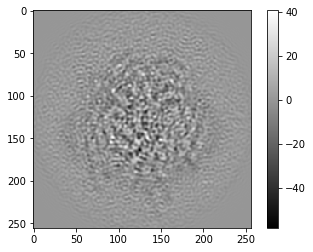

In [73]:

# fig,ax = plt.subplots(1)
# ax.imshow(img2)
# ax.set_xticks([])
# ax.set_yticks([])
# circle2 = plt.Circle((1000, 1000), 150, color='r', fill=False)
# circle3 = plt.Circle((1500, 1000), 150, color='b', fill=False)
# ax.add_patch(circle2)
# ax.add_patch(circle3)

# ax.legend(['a line', 'b line'], loc = 4, fontsize = 'small', ncol = 2)
# plt.savefig('heythere.png', dpi=1000, transparent = True)
img7 = mrc.readMRC('test_folder_2\\28001_20.mrc')[:,:,0]
plt.imshow(img7[384:640,384:640])
plt.colorbar()

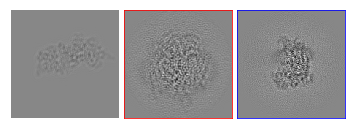

In [3]:
img7 = []
img7 = [mrc.readMRC('test_folder_2\\27001_20.mrc')[:,:,0], mrc.readMRC('test_folder_2\\28001_20.mrc')[:,:,0], mrc.readMRC('test_folder_2\\29001_20.mrc')[:,:,0]]
fig, axes = plt.subplots(nrows = 1, ncols = 3)
colors = [None, 'red', 'blue']
count = 0
for ax in axes.flat:
    im = ax.imshow(img7[count][384:640,384:640], vmin = np.amin(img7), vmax = np.amax(img7))
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor(colors[count])
    count += 1

fig.subplots_adjust(right = 0.9, wspace = 0.05)

# cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
# fig.colorbar(im, cax = cbar_ax)
plt.savefig('lookhere2.png', dpi=4000, transparent = True)

This is the beginning of testing the CTF stuff. Abbas gave me his code which calculates the CTF so I was testing the results it produces on its own and when convolved with an image. 

5616485216.689295


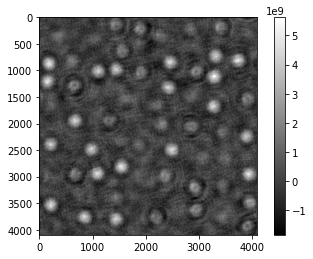

In [268]:
#Testing CTF stuff
img = mrc.readMRC('imgdata_30008_1.mrc')
img = img[:,:,0]
N = 1024
z = ctf.compute_full_ctf(None, N, 2, 300, 2.0, 0.1, 12000, 12000, 0, 1, 10.0)
r = z.reshape([N,N])
# plt.figure()
# plt.imshow(r)
# plt.colorbar()

ted = mrc.readMRC('test_folder_2/28001_20.mrc')
tex = ted[:,:,5]
# plt.figure()
# plt.imshow(tex)
# plt.colorbar()

r2 = np.zeros_like(img)
r2[1536:2560, 1536:2560] = r
tex2 = np.zeros_like(img)
tex2[1536:2560, 1536:2560] = tex

I = np.fft.rfft2(img)
C = np.fft.rfft2(r2)
T = np.fft.rfft2(tex2)
Q =   -2*C*T*I
R = (np.fft.irfft2(Q))
print(np.amax(R))
plt.figure()
plt.imshow(R)
plt.colorbar()
#scipy.misc.imsave('checkme.png',R )

First attempt at implementing the CTF functionality. All it does is caluclate the CTF, and pass its Fourier transform into the code, where it is assumed that now instead of thee Transform of T, every instance is replaced with FT(T)\*FT(CTF). This is a wrong assumption, as the formula for E_jk becomes complex, as such the square is the multiplication of it and its conjugate.
$$ \sum(I_i-T_i)^2 \rightarrow \sum(I_i - CT_i)^2 $$
$$ \sum_\omega||(\tilde{I}_\omega-\tilde{C}_\omega \tilde{T}_\omega)||^2  =  (\tilde{I}_\omega-\tilde{C}_\omega \tilde{T}_\omega)^*(\tilde{I}_\omega-\tilde{C}_\omega \tilde{T}_\omega) $$

Parseval's theorem says this can be calculated as a magnitude in the fourier domain, but I transformed it back.

The normalizations produce very large values in the corners, making this not work at all. Once they are ommitted, it seems to be similar to the expected result, however this is still the improper caluculation due to properties of complex numbers. 

In [76]:
%%time
#Adding the CTF functionality, where you input microscope parameters and get CTF correct probabilities
def Config_Prob(I, folder, rots, psize, akv, csf, wgh, df1, df2, ang, dscale, 
                bfactor, max_num = 10, method = 1, sigma = None, psk = []):
    I = mrc.readMRC(I)
    I = I[:,:,0]
    h , l = I.shape
    
    num_configs = len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name)) and name[0] != '.'])
    
    if sigma is None:
        #Calculate variance for 5 points, 10 times and take median
        avg_num = 50
        sample_num = 100
        sigma_list = np.empty([avg_num,1])
        for nn in range(avg_num):

            x = np.random.randint(0, h, size = sample_num)
            y = np.random.randint(0,l, size = sample_num)
            vbar = 0
            
            for mm in range(sample_num):
                vbar = vbar + I[x[mm]][y[mm]]
                
            sigma = 0
            vbar = vbar * 1/sample_num
            
            for mm in range(sample_num):
                sigma = sigma + (I[x[mm]][y[mm]]- vbar)**2
                
            sigma = sigma * 1/sample_num
            sigma_list[nn] = np.sqrt(sigma)
            
        sigma = statistics.median(sigma_list)[0]
        
        
    else:
        None
        
    print(sigma)
        
    ek_stack = np.empty([num_configs, h, l])
    prob_stack = np.empty([num_configs, h, l])
    
    mask = np.zeros_like(I)
    
    f1 = np.fft.rfft2(I)
    
    if method == 1:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, mask, h, l, 
                    sigma, rots, psize, akv, csf, wgh, df1, df2, ang, dscale,bfactor)
            
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('outerloop')
            
        ek_sum = scipy.misc.logsumexp(-ek_stack, axis = 0)
               
        
        for temp_stack in range(len(os.listdir(folder))):
            
            
            prob = (ek_stack[temp_stack,:,:] + ek_sum)
            prob_stack[temp_stack,:,:] = prob
            
        return (prob_stack, ek_stack, ek_sum)
    
    
    else:
        count = 0
        
       
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, mask, h, l, 
                    sigma, rots, psize, akv, csf, wgh, df1, df2, ang, dscale,bfactor)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('innerloop')
            
        for temp_stack in range(len(os.listdir(folder))):
            
            ek_sum = scipy.misc.logsumexp((np.log(psk[temp_stack])-ek_stack),axis = 0)
            
            prob = -np.log(psk[temp_stack]) + ek_stack[temp_stack,:,:] + ek_sum
          
            prob_stack[temp_stack,:,:] = prob
        
        return (prob_stack, ek_stack, ek_sum)

def Error_Template(I, T, max_num, f1, mask, h, l, 
                   sigma, rots, psize, akv, csf, wgh, df1, df2, ang, dscale,bfactor):
    
    x, y, z = T.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    
    CTF_effect = ctf.compute_full_ctf(None, x, psize, akv, csf, wgh, df1, df2, ang, dscale, bfactor).reshape([x,x])
    
    CTF = np.zeros_like(I)
    CTF[xcent:xcent+int(x), ycent:ycent+int(y)] = CTF_effect
    
    f3 = np.fft.rfft2(CTF)
    
    ek = Template_Splitting(I,T, x, y, z, xcent, ycent, h, l, f1, f3, mask, max_num, sigma)
    
    return ek

def Template_Splitting(I,T, x, y, z, xcent, ycent, h, l, f1, f3, mask, max_num, sigma, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, f3, padding, mask, max_num)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ejk_stack_2 = np.empty([inx_len, h, l])
          
        ejk_stack = np.empty([max_num,h, l])
        

        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([z-index[nn],h,l])      
            
            for xx in range(zed.shape[2]):

                temp = zed[:,:,xx]
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]   
                tex = np.fft.rfft2(mask)
                img_norm = f1**2
                temp_norm = (f3*tex)**2
                
                Q = (img_norm + temp_norm - 2*f1*tex*f3)
                #Q = -2*f3*tex*f1
                R = np.fft.irfft2(Q)
                
                
                ejk_stack[xx,:,:] = (1/(2*sigma**2))*(R)
                
                print('heythere')
            
            ejk_stack_2[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
            print('innerloop')
           
        return ejk_stack_2
    
def fast_convolve(I, T, IFT = None, PFT = None):   
    if IFT is None:
        IFT = np.fft.rfft2(I)

    if PFT is None:
        PFT = np.fft.rfft2(T)

    fc = np.fft.fftshift(np.fft.irfft2(IFT*PFT)) 
   
    return fc        

    
z1 = Config_Prob('imgdata_30008_1.mrc', 'test_folder_3', None, 2, 300, 2.0, 0.1,
                12000, 12000, 0, 1, 10.0,  psk = [0.1, 0.9], method = 1)

24.665340871684016
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere


My attempt to pick aprticles after applying a gaussian blur filter onto it, which actually worked fairly well. But still too arbitrary, I didn't like that. The values used contained in the ek sum calculation, the code passed with a template of zeros, which hoped to negate the blocking and mke the smaller particle stand out more. 

70
Wall time: 14.9 s


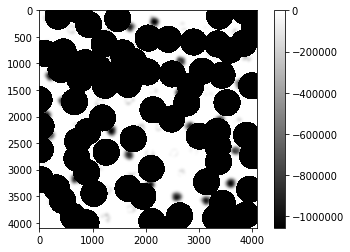

In [42]:
%%time

#New version of picking algorithm for modified images, calculated with a zero stack and changed sigma
#Picking maximal 
#Works for the images ive tried on fairly well, sigma ranging from 25-30
binsize = (250, 250)
array = z1[0][0:3]
array = scipy.misc.logsumexp(-array, axis=0)


#test = array
test = scipy.ndimage.gaussian_filter(array, sigma = 25)
test2 = copy.copy(test)

img2 = scipy.misc.imread('30012_png.png', 1)
n = 4096
r = 256

k,j = 0,0

#50 gives 54, 59-60 gives 63,70 gives 70. 
#for 30004, median/2 gives 40,30012 gets 54
#while np.amin(test)<(np.amax(test2)+np.amin(test2))/7:
while np.amax(test)>np.mean(test2)-np.amax(test2):
    if k == 70:
        break
    else:
        x = np.argmax(test)%4096
        y = np.argmax(test)//4096
        b, a = np.ogrid[-y:n-y, -x:n-x]
        mask = b*b + a*a <= r*r
        img2[y-10:y+10, x-10:x+10] = 0
        k += 1
        #test[y-200:y+200,x-200:x+200] = np.amin(test2)
        test[mask] = np.amin(test2)
        
print(k)
plt.figure()
plt.imshow(test)
plt.colorbar()
#print(dictlist[0], '\n\n', dictlist[1], '\n\n', dictlist[2])
#scipy.misc.imsave('lookhere_30011.png', img2)

In [71]:
z1 = np.load('30008_z1_ctf.npy')

Trying a new way to detect the maximums. 

-1.908261857537327e-05 -1.6399899049625835 -0.18025276063464502 -0.09048812577734378 0.24423901359282912 0.05965269576079817


-0.18023367801606965

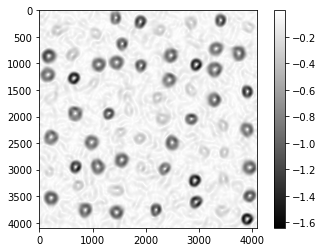

In [7]:
#Trying different combinations for lse and their values

# array = np.empty([6,4096,4096])
# array[0:3,:,:] = z1[0][0:3]
# array[3:6,:,:] = z1[1][0:3]
array = z1[0][0:3]
test = scipy.misc.logsumexp(-array, axis=0)
test = -scipy.ndimage.filters.gaussian_gradient_magnitude(test, sigma = 25)
plt.figure()
plt.imshow(test)
plt.colorbar()
scipy.misc.imsave('lse_ggm.png', test)
print(np.amax(test), np.amin(test), np.mean(test), np.median(test), np.std(test), np.var(test))
np.mean(test)-np.amax(test)

Again, another attempt to pick out where the particles are. This uses a convolution with a circular mask. I do like the results as it highlighted where the particles are, but I didnt know how to process them properly and get an actual location.

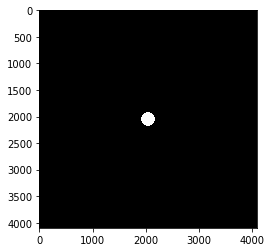

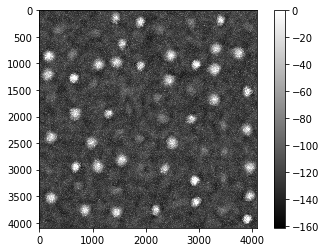

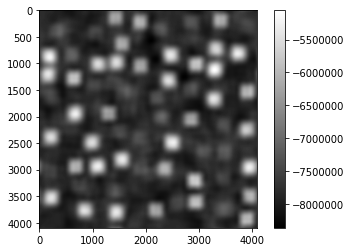

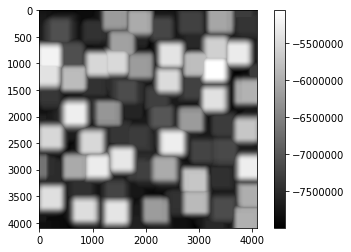

In [25]:
#Attempt at picking particles via convolution with a circular mask
#for 30008 very blurry, and boarders have high value

r = 128
n = 4096
x,y = 2048,2048
b, a = np.ogrid[-y:n-y, -x:n-x]
mask = b*b + a*a <= r*r

mask2 = np.zeros_like(test)
plt.imshow(mask)

array = z1[0][0:3]
test = scipy.misc.logsumexp(-array, axis=0)

plt.figure()
plt.imshow(test)
plt.colorbar()
mask2 = np.zeros_like(test)
mask2[1920:2176, 1920:2176] = 1

def fast_convolve(I, T, IFT = None, PFT = None):   
    if IFT is not None:
        
        f2 = np.fft.rfft2(T)
        
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif PFT is not None:
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc    

R = fast_convolve(test, mask2)


plt.figure()
plt.imshow(R)
plt.colorbar()
scipy.misc.imsave('chekcme10.png', R)

Q = scipy.ndimage.filters.maximum_filter(R, size = (250,250), origin = 0)


plt.figure()
plt.imshow(Q)
plt.colorbar()
#scipy.misc.imsave('chekcme8.png', Q)


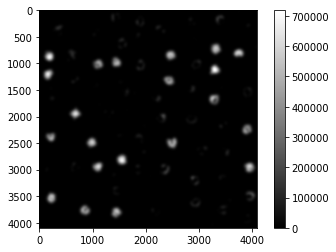

In [78]:
#Playing with idea put forth from online paper
array = z1[0][0:3]
test = -scipy.misc.logsumexp(-array, axis=0)
test = scipy.ndimage.filters.gaussian_filter(test, sigma = 25)

plt.figure()
plt.imshow(test)
plt.colorbar()
#scipy.misc.imsave('lse_ctf_30008_4.png', test)

My display code, the corners fro the CTF code have a much higher value than anywhere else, meaning there is an error in the code. 

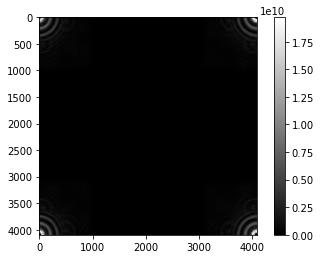

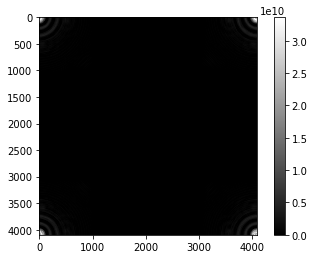

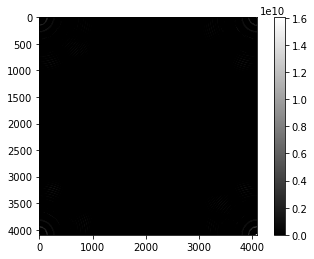

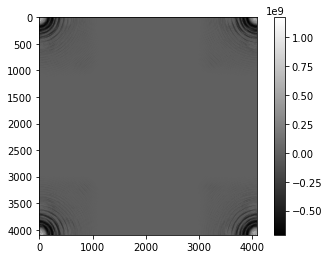

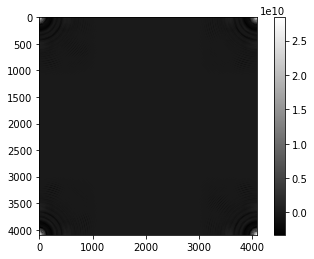

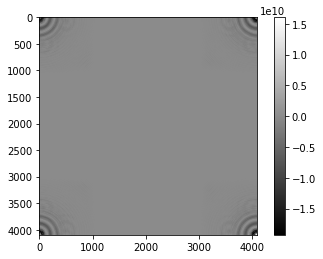

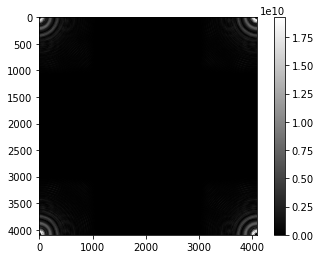

In [77]:
#z1 = np.load('30008_z1.npy')
#Displays the calculated results
# z1[1][0][1][1] = 0
# z1[1][0][1][2] = 0
for nn in range(z1[0].shape[0]-1):
    #-log(P(Sk|I))
#     z1[0][nn,0,0] = 35000
#     z1[0][nn,1,0] = 0
    plt.figure()
    plt.imshow(z1[0][nn,:,:])
    #plt.imshow(z1[0][nn,:,:]/np.amax(z1[0][nn]))
    plt.colorbar()
    scipy.misc.imsave('30008_A_' + str(nn) + '_ctf.png', z1[0][nn,:,:])
    
for mm in range(z1[0].shape[0]-1):
#     z1[1][mm,0,0] = 350000
#     z1[1][mm,1,0] = -2200
    #-logP(I|Sk)
    plt.figure()
    plt.imshow(z1[1][mm,:,:])    
    plt.colorbar()

    scipy.misc.imsave('30008_B_' + str(mm) + '_ctf.png', z1[1][mm,:,:])
    
#-logP(I)
plt.figure()
plt.imshow(z1[2])
plt.colorbar()
scipy.misc.imsave('30008_C_ctf.png', z1[2])

# for nn in range(z1[0].shape[0]):
#     #P(Sk|I)
#     plt.figure()
#     plt.imshow(z1[3][nn,:,:])
#     plt.colorbar()
#     scipy.misc.imsave('30004_D_3' + str(nn) + '.png', z1[3][nn,:,:])

# dred = z1[0][3,:,:]
# dred = -dred
# dred = dred + 1


# plt.imshow(dred)
# plt.colorbar()
# scipy.misc.imsave('yorkA3_2.png', dred)


Trying a whole array fo new things for the particle picking, and trying to balance for the low contrast from the smaller particle. Foremost I tried to normalize the probabilities, didnt help with picking the smaller ones but it was effective (from what I can rememebr) for the larger ones. 

59  Particles 
 [0, 19, 40]
[[3521, 248], [3089, 1987], [3427, 1355], [2845, 3771], [2189, 2188], [1557, 3961], [232, 796], [786, 3443], [3940, 229], [429, 3935], [279, 2391], [148, 1371], [3368, 588], [3213, 3405], [1154, 2039], [1193, 2407], [1156, 978], [427, 3472], [1875, 1464], [918, 3884], [1575, 1900], [1420, 1459], [814, 2933], [1216, 3192], [1680, 2818], [803, 326], [2953, 384], [1913, 905], [3742, 1680], [3490, 2116], [2787, 1509], [935, 1517], [3742, 2767], [393, 1857], [2324, 1707], [1805, 298], [569, 1033], [169, 2987], [3942, 3487], [2431, 159], [2278, 2521], [3022, 3043], [1658, 3320], [2302, 3758], [3780, 1227], [1753, 2431], [559, 1483], [2247, 2873], [2648, 2182], [3482, 3966], [2838, 955], [2402, 966], [764, 2406], [1304, 355], [3090, 2489], [295, 234], [2270, 3373], [3919, 2317], [3906, 751]] 

 [0.00014704731094029443, 0.00030811056396360883, 0.0010483470918336165, 0.001394311757716275, 0.0017628615582004417, 0.0009376249693039026, 0.008035747234152664, 0.003775764

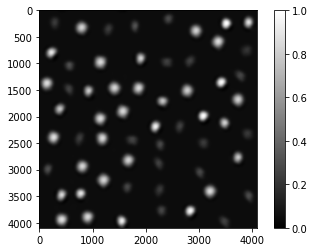

In [12]:
%%time
#Newest version of picking algortihm, after solving particle detection problem
z1 = np.load('30004_z1.npy')
array = z1[0][0:3]
array = scipy.misc.logsumexp(-array, axis=0)

test = scipy.ndimage.gaussian_filter(array, sigma = 25)
test2 = copy.copy(test)

test3 = copy.copy(test2)
test3 = test3+-np.amin(test3)
test3 = test3/np.amax(test3)


z2 = np.zeros_like(z1[0][0:3])
z3 = np.zeros_like(z1[1][0:3])
for x in range(z1[0].shape[0]-1):
    z2[x] = z1[0][x]/np.amax(z1[0][x])
    z3[x] = z1[1][x]/np.amax(z1[1][x])


img2 = scipy.misc.imread('30004_png.png', 1)
img3 = scipy.misc.imread('30004_png.png', 1)



n = 4096
r = 256
k = 0

part_list = []
dictlist = []
counter = []

for xx in range(z1[0].shape[0]-1):
    dictlist.append([])
    counter.append(0)

while np.amax(test)>np.mean(test2)-np.amax(test2):
    if k == 70:
        break
    else:
        x = np.argmax(test)%4096
        y = np.argmax(test)//4096
        part_list.append([x,y])
        b, a = np.ogrid[-y:n-y, -x:n-x]
        mask = b*b + a*a <= r*r
        mask2 = b*b + a*a <= (r*r)/4
        #Some function of probabilities to determine the particle
        #z2 is normalized z1[0] and z3 is normailized z1[1]
        #test3 is the normalized lse of the probabilities
        for xx in range(len(dictlist)):
            #dictlist[xx].append(np.mean(z1[0][xx][mask]))
            dictlist[xx].append(np.mean(z1[0][xx][y-10:y+10,x-10:x+10]/(np.sum(z1[2][y-10:y+10,x-10:x+10]))))
            #dictlist[xx].append(np.mean(z2[xx][y-10:y+10,x-10:x+10])/np.median(z3[xx][y-10:y+10,x-10:x+10]))
            #dictlist[xx].append(-np.log(np.amax(test3[mask]))/np.mean(z1[1][xx][y-10:y+10,x-10:x+10]))
        k += 1
        test[mask] = np.amin(test2)
        
for nn in range(len(part_list)):
    comp_list = []
    location = part_list[nn]
    for xx in range(len(dictlist)):
        comp_list.append(dictlist[xx][nn])
    #min or max?
    particle = comp_list.index(max(comp_list))
    counter[particle] += 1
   
    if particle == 1:
        img3[location[1]-10:location[1]+10, location[0]-10:location[0]+10] = 0
    elif particle == 2:
        img3[location[1]-10:location[1]+10, location[0]-10:location[0]+10] = 255
    else:
        img3[location[1]-20:location[1]+20, location[0]-20:location[0]+20] = 0
        
    
        
print(k , ' Particles' , '\n', counter)
plt.figure()
plt.imshow(test3)
plt.colorbar()
print(part_list, '\n\n', dictlist[0],'\n\n', dictlist[1],'\n\n', dictlist[2])

scipy.misc.imsave('picked_30004_3.png', img3)

Using the CTF images (from improper CTF implementation), I attempt to pick out the particles, which went disasterously. Someitmes the particle was a maximum and sometimes a minimum which really didnt make sense. 

59  Particles 
 [4, 55, 0]
[[912, 3894], [801, 331], [425, 3934], [270, 2394], [1421, 1463], [1212, 3196], [1152, 978], [1578, 1907], [1675, 2822], [816, 2935], [1867, 1467], [152, 1382], [3367, 600], [3216, 3401], [2949, 388], [3739, 1682], [2785, 1512], [1186, 2414], [1150, 2034], [240, 828], [2211, 2210], [1537, 3979], [412, 3455], [3121, 2009], [1898, 898], [3404, 1337], [954, 1520], [380, 1865], [3489, 238], [2814, 3792], [3965, 243], [819, 3445], [3719, 2773], [3465, 2145], [2333, 1725], [762, 2410], [2845, 953], [1664, 3322], [301, 239], [1301, 353], [2309, 3758], [585, 1036], [175, 2980], [1743, 2437], [1810, 297], [2432, 162], [2245, 2868], [3948, 3490], [3090, 2492], [3778, 1221], [3888, 741], [2402, 972], [2265, 3374], [3024, 3039], [2275, 2526], [3917, 2313], [3486, 3967], [2653, 2183], [561, 1477]] 

 [0.97984936875067, 0.9728029787216579, 0.7787664627313934, 0.977895941588747, 0.7236720347259891, 0.8779034038811545, 0.9364501830320623, 0.8297007208833119, 0.97285915327836

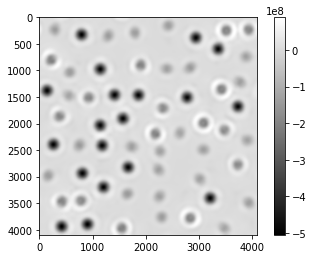

In [22]:
%%time
#Cell for detecting peaks in the CTF generated probabilities
#z1 = np.load('30004_z1_ctf.npy')
array = z1[1][0:3]
array = -scipy.misc.logsumexp(array, axis=0)

test = scipy.ndimage.gaussian_filter(array, sigma = 25)
test2 = copy.copy(test)

img2 = scipy.misc.imread('30004_png.png', 1)
img3 = scipy.misc.imread('30004_png.png', 1)


n = 4096
r = 256
k = 0

part_list = []
dictlist = []
counter = []

for xx in range(z1[0].shape[0]-1):
    dictlist.append([])
    counter.append(0)

while np.amin(test)<np.mean(test2)-np.amax(test2):
    if k == 70:
        break
    else:
        x = np.argmin(test)%4096
        y = np.argmin(test)//4096
        part_list.append([x,y])
        b, a = np.ogrid[-y:n-y, -x:n-x]
        mask = b*b + a*a <= r*r
        mask2 = b*b + a*a <= (r*r)/4
        for xx in range(len(dictlist)):    
            dictlist[xx].append(np.mean(z1[0][xx][y-10:y+10,x-10:x+10]/np.amax(z1[0][xx][mask])))
        k += 1
        img2[y-10:y+10, x-10:x+10] = 0
        test[mask] = np.amax(test2)
                
for nn in range(len(part_list)):
    comp_list = []
    location = part_list[nn]
    for xx in range(len(dictlist)):
        comp_list.append(dictlist[xx][nn])
    #min or max?
    particle = comp_list.index(max(comp_list))
    counter[particle] += 1
   
    if particle == 1:
        img3[location[1]-10:location[1]+10, location[0]-10:location[0]+10] = 0
    elif particle == 2:
        img3[location[1]-10:location[1]+10, location[0]-10:location[0]+10] = 255
    else:
        img3[location[1]-20:location[1]+20, location[0]-20:location[0]+20] = 0
        
        
print(k , ' Particles' , '\n', counter)
plt.figure()
plt.imshow(test2)
plt.colorbar()
print(part_list, '\n\n', dictlist[0],'\n\n', dictlist[1],'\n\n', dictlist[2])

scipy.misc.imsave('picked_30004_5.png', img3)

Playing around with the CTF, trying to get what I thught was the right way to do it to work. 

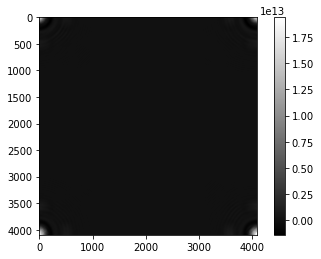

In [75]:
def fast_convolve(I, T, IFT = None, PFT = None):   
    if IFT is None:
        IFT = np.fft.rfft2(I)

    if PFT is None:
        PFT = np.fft.rfft2(T)

    fc = np.fft.fftshift(np.fft.irfft2(IFT*PFT)) 
   
    return fc        


img = mrc.readMRC('imgdata_30008_1.mrc')
img = img[:,:,0]
template = mrc.readMRC('test_folder_2/28001_20.mrc')
temp = template[:,:,0]
#noisy_image = G = np.random.normal(0,1,16777216).reshape([4096,4096])

#From micrograph data
sigma = 24.9

padding = np.zeros_like(img)
padding[1536:2560,1536:2560] = 1

img_norm = fast_convolve(img**2, padding)
temp_norm = np.sum(temp**2)

temp_pad = np.zeros_like(img)
temp_pad[1536:2560,1536:2560] = temp[::-1,::-1]

cross_corr = fast_convolve(img, temp_pad)
normalized_cross_corr = 1/(2*sigma**2)*(img_norm + temp_norm - 2*cross_corr)

#CTF affected code

#def compute_full_ctf(rots,N,psize,akv,csf,wgh,dfmid1,dfmid2,angastf,dscale,bfactor)
CTF_effect = ctf.compute_full_ctf(None, 1024, 2.0,300, 2, 0.1, 12000, 12000,  0, 1, 10).reshape([1024,1024])
CTF = np.zeros_like(img)
CTF[1536:2560,1536:2560] = CTF_effect

fourier_image = np.fft.rfft2(img)
fourier_ctf = np.fft.rfft2(CTF)
fourier_temp = np.fft.rfft2(temp_pad)

img_norm_ctf = fourier_image**2
temp_norm_ctf = (fourier_ctf*fourier_temp)**2
cross_corr_ctf = -2*fourier_image*fourier_ctf*fourier_temp
normalized_cross_corr_ctf =  1/(2*sigma**2)*np.fft.irfft2(img_norm_ctf + temp_norm_ctf + cross_corr_ctf)
#reverted from Fourier space using np.fft.rfft2()

#Same code tested on a unifromaly noisy micrograph, sigma = 1, mu = 0
img_norm_noisy = fast_convolve(noisy_image**2, padding)
cross_corr_noisy = fast_convolve(noisy_image, temp_pad)
normalized_cross_corr_noisy = 1/(2)*(img_norm_noisy + temp_norm - 2*cross_corr_noisy)

fourier_image_noisy = np.fft.rfft2(noisy_image)

img_norm_ctf_noisy = fourier_image_noisy**2
cross_corr_ctf_noisy = -2*fourier_image_noisy*fourier_ctf*fourier_temp
normalized_cross_corr_ctf_noisy =  1/(2)*np.fft.irfft2(img_norm_ctf_noisy + temp_norm_ctf + cross_corr_ctf_noisy)


# image = (normalized_cross_corr_ctf_noisy)


# plt.figure()
# plt.imshow(image)
# plt.colorbar()
# scipy.misc.imsave('normalized_cross_correlation_ctf_noisy.png', image)

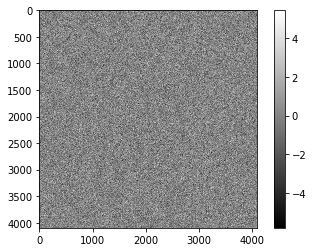

In [45]:
G = np.random.normal(0,1,16777216).reshape([4096,4096])

plt.figure()
plt.imshow(G)
plt.colorbar()

scipy.misc.imsave('noisy_test.png', G)
plt.savefig('heyther.png')

In [2]:
time.time()

1532122215.5003614